In [1]:
%cd ..

/mnt/e/projects/face_recognition


In [2]:
from tqdm import tqdm

import albumentations as A

import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from oml import datasets as d
from oml.inference import inference
from oml.losses import TripletLossWithMiner
from oml.metrics import calc_retrieval_metrics_rr
from oml.miners import AllTripletsMiner

from oml.retrieval import AdaptiveThresholding, RetrievalResults
from oml.samplers import BalanceSampler

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_v2_s
from pathlib import Path

from config import CFG
from dataset import get_data_train_and_data_irm, get_valid_dataset

device = "cuda"

In [3]:
df_train, data_irm = get_data_train_and_data_irm(
    min_number_of_photo=10, max_number_of_photo=10, train_reset_labels=False
)
df_valid = get_valid_dataset(data_irm, valid_size=2000)

Число уникальных людей 10174. Всего фото 194716
Датасет для тренировки содержит 6000 людей
data 194716 -> train_data 60000 data_irm 42753


In [4]:
df_valid.sample(5)

,path,is_query,is_gallery,label,split
208,077012.jpg,False,True,6808,valid
588,145623.jpg,True,False,5738,valid
1981,142804.jpg,True,False,2025,valid
341,054214.jpg,False,True,9459,valid
1473,171046.jpg,False,True,2211,valid


In [5]:
transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = d.ImageLabeledDataset(df_train, transform=transform, dataset_root=Path(CFG.img_folder_dst))
validate_dataset = d.ImageQueryGalleryLabeledDataset(
    df_valid, transform=transform, dataset_root=Path(CFG.img_folder_dst)
)

In [6]:
model = efficientnet_v2_s()
model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features=1280, out_features=2024))
model.load_state_dict(torch.load("models/efficientnet_v2_s_ce_10_epoch.pth"))
model.classifier = nn.Sequential()
model.eval()
model = model.to(device)
None

In [26]:
def validation(model):
    model.eval()
    embeddings = inference(model, validate_dataset, batch_size=4, num_workers=0)
    rr = RetrievalResults.from_embeddings(embeddings, validate_dataset, n_items=3)
    rr = AdaptiveThresholding(n_std=2).process(rr)
    rr.visualize(query_ids=[1, 2], dataset=validate_dataset, show=True)
    print(calc_retrieval_metrics_rr(rr, map_top_k=(3,), cmc_top_k=(1,)))

/home/rrrr/miniconda3/envs/main/lib/python3.10/site-packages/oml/retrieval/retrieval_results.py:394: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


CMC@1:   0%|          | 0/668 [00:00<?, ?it/s]

Precision@5:   0%|          | 0/668 [00:00<?, ?it/s]

MAP@3:   0%|          | 0/668 [00:00<?, ?it/s]

{'cmc': {1: tensor(0.6916)}, 'precision': {5: tensor(0.6065)}, 'map': {3: tensor(0.7265)}}


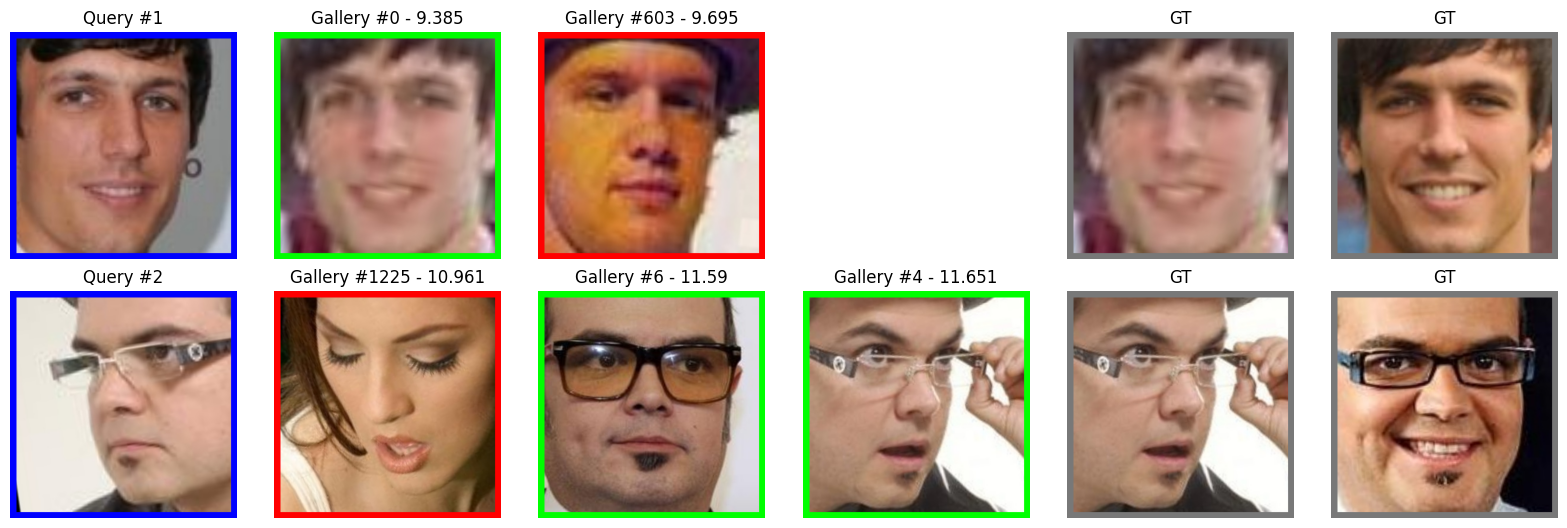

In [8]:
# метрики не до ученой(baseline) модели на CE, с accuracy 78%
validation(model)

In [22]:
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = TripletLossWithMiner(0.1, AllTripletsMiner(), need_logs=True)
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=3, n_instances=8)

In [23]:
EPOCH = 20


def training():
    # TODO добавить шедулер
    model.train()
    for _ in range(EPOCH):
        for batch in tqdm(DataLoader(train_dataset, batch_sampler=sampler)):
            embeddings = model(batch["input_tensors"].to(device))
            loss = criterion(embeddings, batch["labels"].to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print(criterion.last_logs)

In [24]:
training()

100%|██████████| 2000/2000 [09:32<00:00,  3.50it/s]


{'active_tri': 0.00037202381645329297, 'pos_dist': 8.770753860473633, 'neg_dist': 14.274321556091309}


100%|██████████| 2000/2000 [09:20<00:00,  3.57it/s]


{'active_tri': 0.0007440476329065859, 'pos_dist': 7.028962135314941, 'neg_dist': 10.74674129486084}


100%|██████████| 2000/2000 [09:54<00:00,  3.36it/s]


{'active_tri': 0.02008928544819355, 'pos_dist': 6.19473123550415, 'neg_dist': 9.052481651306152}


100%|██████████| 2000/2000 [10:18<00:00,  3.23it/s]


{'active_tri': 0.0349702388048172, 'pos_dist': 5.2376627922058105, 'neg_dist': 6.834469318389893}


100%|██████████| 2000/2000 [10:04<00:00,  3.31it/s]


{'active_tri': 0.0074404762126505375, 'pos_dist': 4.5264692306518555, 'neg_dist': 6.827946186065674}


100%|██████████| 2000/2000 [09:15<00:00,  3.60it/s]


{'active_tri': 0.0, 'pos_dist': 3.7421860694885254, 'neg_dist': 6.329479694366455}


100%|██████████| 2000/2000 [09:10<00:00,  3.63it/s]


{'active_tri': 0.0349702388048172, 'pos_dist': 3.381943941116333, 'neg_dist': 4.666953086853027}


100%|██████████| 2000/2000 [10:18<00:00,  3.23it/s]


{'active_tri': 0.0531994067132473, 'pos_dist': 3.0130155086517334, 'neg_dist': 3.836183786392212}


100%|██████████| 2000/2000 [10:09<00:00,  3.28it/s]


{'active_tri': 0.0096726194024086, 'pos_dist': 2.7519850730895996, 'neg_dist': 4.465266227722168}


100%|██████████| 2000/2000 [09:55<00:00,  3.36it/s]


{'active_tri': 0.0319940485060215, 'pos_dist': 2.8894431591033936, 'neg_dist': 3.8844923973083496}


100%|██████████| 2000/2000 [09:59<00:00,  3.33it/s]


{'active_tri': 0.01302083395421505, 'pos_dist': 2.361942768096924, 'neg_dist': 3.2665107250213623}


100%|██████████| 2000/2000 [09:55<00:00,  3.36it/s]


{'active_tri': 0.0007440476329065859, 'pos_dist': 2.2429354190826416, 'neg_dist': 3.5114004611968994}


100%|██████████| 2000/2000 [09:49<00:00,  3.39it/s]


{'active_tri': 0.007068452425301075, 'pos_dist': 2.130826711654663, 'neg_dist': 2.914642333984375}


100%|██████████| 2000/2000 [09:57<00:00,  3.35it/s]


{'active_tri': 0.0234375, 'pos_dist': 2.2618558406829834, 'neg_dist': 3.139629602432251}


100%|██████████| 2000/2000 [09:36<00:00,  3.47it/s]


{'active_tri': 0.00632440485060215, 'pos_dist': 2.1710541248321533, 'neg_dist': 2.9807815551757812}


100%|██████████| 2000/2000 [09:11<00:00,  3.63it/s]


{'active_tri': 0.0011160714784637094, 'pos_dist': 2.0837504863739014, 'neg_dist': 3.1933202743530273}


100%|██████████| 2000/2000 [08:58<00:00,  3.71it/s]


{'active_tri': 0.0, 'pos_dist': 2.0668065547943115, 'neg_dist': 3.668285608291626}


100%|██████████| 2000/2000 [09:31<00:00,  3.50it/s]


{'active_tri': 0.0, 'pos_dist': 1.9513317346572876, 'neg_dist': 3.1878230571746826}


100%|██████████| 2000/2000 [09:57<00:00,  3.35it/s]


{'active_tri': 0.0505952388048172, 'pos_dist': 1.9300984144210815, 'neg_dist': 2.7435030937194824}


100%|██████████| 2000/2000 [09:55<00:00,  3.36it/s]

{'active_tri': 0.0, 'pos_dist': 2.023268938064575, 'neg_dist': 3.510965347290039}


/home/rrrr/miniconda3/envs/main/lib/python3.10/site-packages/oml/retrieval/retrieval_results.py:394: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


CMC@1:   0%|          | 0/668 [00:00<?, ?it/s]

Precision@5:   0%|          | 0/668 [00:00<?, ?it/s]

MAP@3:   0%|          | 0/668 [00:00<?, ?it/s]

{'cmc': {1: tensor(0.8323)}, 'precision': {5: tensor(0.7520)}, 'map': {3: tensor(0.8554)}}


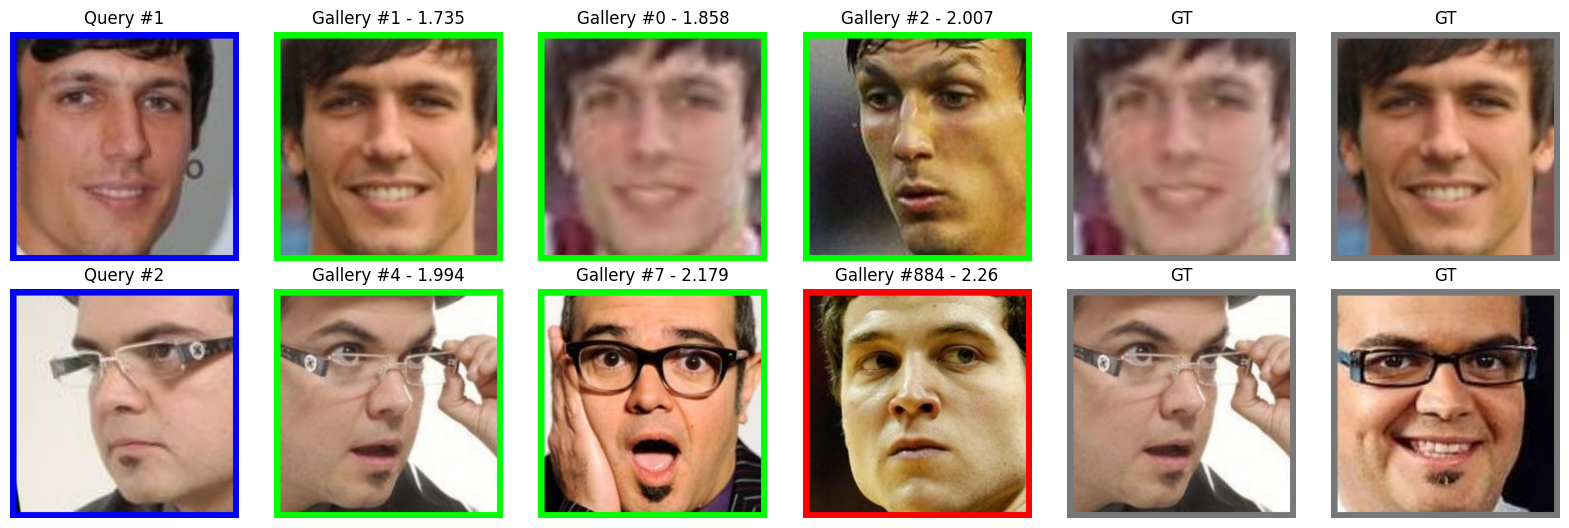

In [28]:
# метрики подросли
validation(model=model)

In [29]:
torch.save(model.state_dict(), "models/efficientnet_v2_s_tl_20_epoch.pth")